<img src="https://static.wikia.nocookie.net/fallout/images/a/ad/SmoothTalker.png"/><p></p>

#  Проект 5. Выбираем авто выгодно

### Цель проекта
Создать модель, прогнозирующую рыночные цены машин BMW в Москве и области на основании описывающих их параметров.

В проекте отсутствуют тренировочные данные, поэтому мы их будем дополнительно собирать парсером с сайта Авто.ру (отдельный файл, т.к. не получилось напрямую качать и парсить прямо с Kaggle).

### Признаки тестового набора
* bodyType - тип кузова;
* brand - марка машины (БМВ);
* color - цвет машины;
* fuelType - тип горючего;
* modelDate - год начала выпуска данной модули;
* name - сборный признак, содержащий информацию о моделе, коробке передач и мощности двигателя;
* numberOfDoors - кол-во дверей;
* productionDate - год производства конкретной машины;
* vehicleConfiguration - словарь, содержащий конфигурацию кузова, коробки передач и объёма двигателя; 
* vehicleTransmission - тип коробки передач;
* engineDisplacement - объём двигателя в литрах;
* enginePower - мощность двигателя в л.с.;
* description - словесное, неструктурированное описание выставленной на продажу машины;
* mileage - пробег в км;
* Комплектация - комбинированное поле-словарь, содержащее комплектацию информацию о комплектации;
* Привод - тип привода;
* Руль - руль: левый или правый;
* Состояние - общее состояние машины с точки зрения необходимого ремонта;
* Владельцы - кол-во предыдущих владельцев;
* ПТС - наличие и вид паспорта транспортного средства;
* Таможня - растаможена ли машина;
* Владение - время владения (лет и месяцев)
* id - идентификатор записи.

**Целевая переменная**: <span style="color:red">price</span> - цена машины в рублях.

## 1. Импорт библиотек и ключевые параметры

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
import ast

from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import make_scorer
from sklearn.feature_selection import f_classif

from tqdm.notebook import tqdm

pd.options.display.max_columns = None # Выводить все колонки

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
RANDOM_SEED = 42
VERSION     = 6
DIR_TRAIN   = '../input/project-5-training-dataset/' # подключил к ноутбуку свой внешний датасет
DIR_TEST    = '../input/sf-dst-car-price/'
VAL_SIZE    = 0.25
N_FOLDS     = 5
FX_COEF     = 63.9798 / 76.8395                      # https://www.kursvaliut.ru/c%D1%80%D0%B5%D0%B4%D0%BD%D0%B8%D0%B9-%D0%BA%D1%83%D1%80%D1%81-%D0%B2%D0%B0%D0%BB%D1%8E%D1%82-%D0%B7%D0%B0-%D0%BC%D0%B5%D1%81%D1%8F%D1%86-2020

# CATBOOST
ITERATIONS  = 2000
LR          = 0.1

---
## 2. Загрузка и первичная предобработка данных

In [5]:
train = pd.read_csv(DIR_TRAIN+'train.csv') # датасет для обучения модели

test = pd.read_csv(DIR_TEST+'test.csv')

sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [6]:
train.sample(5)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_info,model_name,name,numberOfDoors,price,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
206,внедорожник 5 дв.,BMW,коричневый,"{'id': '21624224', 'name': 'M50i', 'available_...",Только в РОЛЬФ ПРЕМИУМ лимитированная Online s...,4.4,530.0,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,0.0,2019.0,"{'code': 'X6', 'name': 'X6', 'ru_name': 'Х6', ...",X6,M50i 4.4 AT (530 л.с.) 4WD,5.0,8669000.0,2020.0,1101199931,"{'id': '21610786', 'name': 'III (G06)', 'ru_na...",ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,EUROPEAN,NaN,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
1234,седан long,BMW,чёрный,{'id': '0'},РОЛЬФ Премиум – крупнейший официальный дилер М...,3.0,249.0,"{'cruise-control': True, 'asr': True, 'start-s...",дизель,28105.0,2019.0,"{'code': '7ER', 'name': '7 серии', 'ru_name': ...",7ER,730Ld xDrive 3.0d AT (249 л.с.) 4WD,4.0,6079000.0,2019.0,1100714352,"{'id': '21473050', 'name': 'VI (G11/G12) Реста...",SEDAN AUTOMATIC 3.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
2299,внедорожник 5 дв.,BMW,серый,{'id': '0'},++ Навигация с дорожным трафиком.\n++ Монитор ...,2.0,150.0,"{'cruise-control': True, 'asr': True, 'esp': T...",дизель,43000.0,2015.0,"{'code': 'X1', 'name': 'X1', 'ru_name': 'Х1', ...",X1,18d xDrive 2.0d AT (150 л.с.) 4WD,5.0,2350000.0,2018.0,1101745775,"{'id': '20583308', 'name': 'II (F48)', 'ru_nam...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,1 владелец,"{'year': 2019, 'month': 3}",Оригинал,полный,Левый,Не требует ремонта,Растаможен
3484,внедорожник 5 дв.,BMW,серый,"{'id': '21558678', 'name': 'xDrive20i Urban', ...",Мы открыты! Купите новый BMW быстро и абсолютн...,2.0,184.0,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,0.0,2017.0,"{'code': 'X3', 'name': 'X3', 'ru_name': 'Х3', ...",X3,20i xDrive 2.0 AT (184 л.с.) 4WD,5.0,3730000.0,2020.0,1101681955,"{'id': '21029610', 'name': 'III (G01)', 'ru_na...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,NaN,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
3626,внедорожник 5 дв.,BMW,чёрный,{'id': '0'},Ограничений нет! Старый штраф 500 рублей проср...,3.0,272.0,"{'esp': True, 'start-stop-function': True, 'ai...",бензин,132000.0,2006.0,"{'code': 'X5', 'name': 'X5', 'ru_name': 'Х5', ...",X5,30i 3.0 AT (272 л.с.) 4WD,5.0,949000.0,2009.0,1101790741,"{'id': '2305679', 'name': 'II (E70)', 'ru_name...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3674 entries, 0 to 3673
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3674 non-null   object 
 1   brand                 3674 non-null   object 
 2   color                 3674 non-null   object 
 3   complectation_dict    3674 non-null   object 
 4   description           3586 non-null   object 
 5   engineDisplacement    3674 non-null   float64
 6   enginePower           3674 non-null   float64
 7   equipment_dict        3674 non-null   object 
 8   fuelType              3674 non-null   object 
 9   mileage               3674 non-null   float64
 10  modelDate             3674 non-null   float64
 11  model_info            3674 non-null   object 
 12  model_name            3674 non-null   object 
 13  name                  3674 non-null   object 
 14  numberOfDoors         3674 non-null   float64
 15  price                

In [8]:
test.sample(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
2686,внедорожник 5 дв.,BMW,чёрный,дизель,2013.0,40d 3.0d AT (313 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,313 N12,Автомобиль BMW X5 от Авилон – это: \n\n• Обсл...,123202.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,2686
1129,хэтчбек 5 дв.,BMW,белый,бензин,2011.0,118i 1.6 AT (170 л.с.),5.0,2011.0,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,1.6 LTR,170 N12,Авто купил в ноябре 2015 г. за наличные. Обслу...,125000.0,"['[{""name"":""Салон"",""values"":[""Тонированные сте...",задний,Левый,Не требует ремонта,3 или более,Дубликат,Растаможен,4 года и 2 месяца,1129
795,седан,BMW,синий,дизель,2013.0,520d 2.0d AT (190 л.с.),4.0,2016.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,Один владелец. \nОбслуживание у официально дил...,26129.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,3 года и 4 месяца,795
1529,внедорожник 5 дв.,BMW,коричневый,дизель,2010.0,40d 3.0d AT (306 л.с.) 4WD,5.0,2010.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,306 N12,"Состояние идеальное. Продаю без спешки, салона...",204000.0,"['[{""name"":""Салон"",""values"":[""Тонированные сте...",полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,NaN,1529
861,внедорожник 5 дв.,BMW,серебристый,бензин,2003.0,3.0i 3.0 AT (231 л.с.) 4WD,5.0,2006.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,231 N12,"Продается отличный икс. В идеальном состоянии,...",300000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,2 года,861


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3837 non-null   object 
 1   brand                 3837 non-null   object 
 2   color                 3837 non-null   object 
 3   fuelType              3837 non-null   object 
 4   modelDate             3837 non-null   float64
 5   name                  3837 non-null   object 
 6   numberOfDoors         3837 non-null   float64
 7   productionDate        3837 non-null   float64
 8   vehicleConfiguration  3837 non-null   object 
 9   vehicleTransmission   3837 non-null   object 
 10  engineDisplacement    3837 non-null   object 
 11  enginePower           3837 non-null   object 
 12  description           3837 non-null   object 
 13  mileage               3837 non-null   float64
 14  Комплектация          3837 non-null   object 
 15  Привод               

### Приводим к общему виду оба набора данных
Т.к. данные собраны в разное время разными людьми и разным способом (хоть и из одного источника), надо их привести к одинаковому виду.
1. Сравним наличие разницы в признаках в обоих наборах;
2. Проверим, что нет повторяющихся идентификаторов в обоих наборах данных (иначе это приведёт к переобучению);
3. Объединим оба набора в один общий;
4. Проверим содержимое столбцов в обоих наборах;
5. Посмотрим самые частые значения по наборам, чтобы убедиться что нет разницы в форматах и дисбаланса в данных;
6. Приведём все различающиеся признаки к единому виду, который они имеют в тестовом наборе.

### 2.1 Сравним столбцы в обоих наборах

In [10]:
def compare_datasets(train, test):
    '''
    Функция, которая сравнивает признаки тренировочного и тестового наборов данных.
    '''
    train_features = train.columns
    test_features = test.columns

    
    print(f'Признаки, отсутствующие в тестовом наборе:')
    
    for train_feature in train_features:
        if train_feature not in test_features:
            print(train_feature)

            
    print(f'\n--------------------------\n' \
          'Признаки, отсутствующие в тренировочном наборе:')
    
    for test_feature in test_features:
        if test_feature not in train_features:
            print(test_feature)

In [11]:
compare_datasets(train, test)

Признаки, отсутствующие в тестовом наборе:
complectation_dict
equipment_dict
model_info
model_name
price
sell_id
super_gen
vendor

--------------------------
Признаки, отсутствующие в тренировочном наборе:
Комплектация
id


**Вывод**
* Парсил изначально больше признаков с заделом на расширение набора признаков, но из-за их отсутствия в тестовом наборе и потому, что они часто дублируются с данными в других колонках, сбросим equipment_dict, model_info, model_name, super_gen, vendor;
* brand = 'BMW' в обоих наборах, можно удалить;
* id пока оставим - на его основании проверим наличие дубликатов в обоих наборах данных;
* Отсутствие цены (price) в тестовом наборе естественно - это целевая переменная;
* Комплектация (она же complectation_dict) разрознена, поэтому выбросим её из обоих наборов: для поиска конкретных комплектующих позже воспользуемся описанием машины (description).

### 2.2 Проверим, что нет повторяющихся идентификаторов в обоих наборах данных

In [12]:
# Объединим оба набора на основании id

joined = train.merge(test, left_on='sell_id', right_on='id', how='inner')
    
print(train.shape, joined.shape, f'\nОстанется {train.shape[0] - joined.shape[0]} записей без совпадений.')

(3674, 29) (0, 52) 
Останется 3674 записей без совпадений.


In [13]:
test['id'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64

**Вывод**
* id, увы, на проверку на дубликаты не пригоден - в отличие от тренировочного набора, в тестовом это просто порядковый номер записи, поэтому тоже удалим.

### 2.3 Объединим оба набора в один общий

In [14]:
# Дополним колонку с ценой, чтоб объединить оба набора и удалим лишние и дублирующиеся столбцы (см. 2.1).

test['price'] = None

test.drop(['brand', 'Комплектация', 'id', 'name', 'vehicleConfiguration'], axis=1, inplace=True)

train.drop(['brand', 'complectation_dict', 'equipment_dict', 'model_info',
            'model_name', 'name', 'sell_id', 'super_gen', 'vehicleConfiguration', 'vendor'], axis=1, inplace=True)

In [15]:
# Удаляем из данных дубликаты

train.drop_duplicates(ignore_index=True, inplace=True)

In [16]:
train['train'] = 1 # помечаем где у нас трейн

test['train'] = 0 # помечаем где у нас тест

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

print(data.shape, train.shape, test.shape, train.shape[0] + test.shape[0] == data.shape[0])

(7196, 20) (3359, 20) (3837, 20) True


### 2.4 Проверим содержимое столбцов в обоих наборах

In [17]:
# Составим список колонок, которые имеет смысл сравнить / привести к общему виду

features =  ['bodyType', 'color', 'engineDisplacement', 'enginePower',
             'fuelType', 'modelDate', 'numberOfDoors', 'productionDate',
             'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 
             'Руль', 'Состояние', 'Таможня']

In [18]:
def compare_features(features=features):
    '''
    Смотрим какие значения в тестовой выборке не представлены в тренировочном наборе:
    или у нас проблема с форматом входных данных, или это проблема, т.к. мы ухудшаем
    предсказательную способность модели.
    '''

    for feature in features:
        print(f'Сравниваю признак {feature}: ', end='')

        unique_vals_train = data[data['train'] == 1][feature].unique()
        unique_vals_test  = data[data['train'] == 0][feature].unique()
        not_found = []

        for unique_val_test in unique_vals_test:
            if unique_val_test not in unique_vals_train:
                not_found.append(unique_val_test)

        if len(not_found) > 0:
            print(f'в тренировочном наборе НЕ найдены следующие значения: {not_found} из {len(unique_vals_test)} сравниваемых!')
        else:
            print(f'все значения признака совпали.\n', '-' * 50, '\n', end='')

In [19]:
compare_features()

Сравниваю признак bodyType: в тренировочном наборе НЕ найдены следующие значения: ['лифтбек'] из 11 сравниваемых!
Сравниваю признак color: все значения признака совпали.
 -------------------------------------------------- 
Сравниваю признак engineDisplacement: в тренировочном наборе НЕ найдены следующие значения: ['2.0 LTR', '4.4 LTR', '3.0 LTR', '1.6 LTR', '2.5 LTR', '4.8 LTR', '2.2 LTR', '6.6 LTR', '1.5 LTR', '6.0 LTR', '1.8 LTR', '3.5 LTR', '2.8 LTR', '4.0 LTR', '3.6 LTR', '5.4 LTR', '2.9 LTR', 'undefined LTR', '1.9 LTR', '5.0 LTR', '4.6 LTR', '3.4 LTR'] из 22 сравниваемых!
Сравниваю признак enginePower: в тренировочном наборе НЕ найдены следующие значения: ['190 N12', '150 N12', '407 N12', '249 N12', '381 N12', '245 N12', '177 N12', '184 N12', '115 N12', '231 N12', '156 N12', '306 N12', '218 N12', '136 N12', '235 N12', '286 N12', '122 N12', '265 N12', '258 N12', '340 N12', '355 N12', '170 N12', '333 N12', '192 N12', '610 N12', '264 N12', '555 N12', '313 N12', '272 N12', '450 N12', 

**Вывод**
* В тренировочном датасете не оказалось лифтбеков (но их всего 11 в тесте);
* Есть пара несущественных отсутствий по годам производства (1981 и 1987 года);
* Есть несовпадения в engineDisplacement, enginePower, name, vehicleConfiguration, Владение - судя по обилию, проблема в разном формате данных.

### 2.5 Посмотрим самые частые значения (категориальные признаки) и распределение (числовые признаки)

In [20]:
for feature in features:
    print(data.groupby(['train'])[feature].value_counts().nlargest(5), '\n', '-' * 50, '\n', end='')

train  bodyType         
1      внедорожник 5 дв.    1658
0      внедорожник 5 дв.    1626
       седан                1594
1      седан                1062
0      купе                  214
Name: bodyType, dtype: int64 
 -------------------------------------------------- 
train  color 
0      чёрный    1395
1      чёрный    1347
0      белый      767
1      белый      656
0      синий      510
Name: color, dtype: int64 
 -------------------------------------------------- 
train  engineDisplacement
0      2.0 LTR               1538
       3.0 LTR               1353
1      2.0                   1312
       3.0                   1267
       4.4                    337
Name: engineDisplacement, dtype: int64 
 -------------------------------------------------- 
train  enginePower
0      184 N12        636
1      249.0          511
       184.0          464
0      249 N12        300
       245 N12        293
Name: enginePower, dtype: int64 
 -------------------------------------------------- 

In [21]:
# engineDisplacement - уберём в тесте суффикс ' LTR'

data.loc[data['train'] == 0, ['engineDisplacement']] = data['engineDisplacement'].apply(lambda x: x.replace(' LTR', '') if isinstance(x, str) else x)


# Приведём все значения к формату числа с плавающей точкой (неопределённые значения будут конвертированы в NaN)

data['engineDisplacement'] = pd.to_numeric(data['engineDisplacement'], errors='coerce')
    
compare_features(['engineDisplacement'])

Сравниваю признак engineDisplacement: в тренировочном наборе НЕ найдены следующие значения: [nan, 4.6] из 22 сравниваемых!


In [22]:
# enginePower - уберём в тесте суффикс ' N12'

data.loc[data['train'] == 0, ['enginePower']] = data['enginePower'].apply(lambda x: x.replace(' N12', '') if isinstance(x, str) else x)


# Приведём все значения к формату числа с плавающей точкой (неопределённые значения будут конвертированы в NaN)

data['enginePower'] = pd.to_numeric(data['enginePower'], errors='coerce')

compare_features(['enginePower'])

Сравниваю признак enginePower: в тренировочном наборе НЕ найдены следующие значения: [460.0, 410.0, 347.0, 449.0, 243.0, 230.0] из 75 сравниваемых!


In [23]:
# Владение - разница в формате данных

print(data[(data['train'] == 0) & (~data['Владение'].isna())]['Владение'].sample(5))

print(data[(data['train'] == 1) & (~data['Владение'].isna())]['Владение'].sample(5))

322      4 года и 2 месяца
2999     3 года и 4 месяца
2829    5 лет и 10 месяцев
656               3 месяца
987       6 лет и 2 месяца
Name: Владение, dtype: object
5605     {'year': 2014, 'month': 5}
6567    {'year': 2016, 'month': 12}
6087     {'year': 2016, 'month': 2}
6774     {'year': 2013, 'month': 8}
5815     {'year': 2020, 'month': 2}
Name: Владение, dtype: object


In [24]:
def ownership_to_months_test(ownership):
    '''
    Переводим текстовый формат регулярных выражений времени владения (в тестовом наборе)
    в кол-во месяцев и возвращаем их как результат.
    '''
    pattern = re.compile('\d+\s[а-яё]+')
    y = 0
    m = 0
    
    try:
        for p in pattern.findall(ownership):
            if 'год' in p or 'лет' in p:
                y = int(p[:2].replace(' ', '')) * 12
            if 'месяц' in p:
                m = int(p[:2].replace(' ', ''))
    except:
        return None
    
    return y + m

In [25]:
def ownership_to_months_train(ownership):
    '''
    Переводим формат словаря (в тренировочном наборе) в кол-во месяцев и возвращаем их как результат.
    '''
    year_ref = 2020  # Год, когда мы скачивали тренировочные данные
    month_ref = 11   # Последний оконченный месяц, когда мы скачивали тренировочные данные
    y = 0
    m = 0
    
    try:
        for key, value in ast.literal_eval(ownership).items():
            if key == 'year':
                y = (year_ref - value) * 12
            if key == 'month':
                m = month_ref - value
    except:
        return None
    
    return y + m

In [26]:
data.loc[data['train'] == 1, 'ownership_mo'] = data['Владение'].apply(ownership_to_months_train)

data.loc[data['train'] == 0, 'ownership_mo'] = data['Владение'].apply(ownership_to_months_test)

print(data['ownership_mo'].value_counts(dropna=False))

print(f'\nПропусков в обработанном признаке {len(data[data["ownership_mo"].isna()])}, и {len(data[data["Владение"].isna()])} в оригинальном.')

data.drop('Владение', axis=1, inplace=True)

# Уберём также из списка сравниваемых признаков

features.remove('Владение')

NaN      4824
16.0       54
13.0       49
14.0       48
20.0       47
         ... 
228.0       1
155.0       1
133.0       1
201.0       1
119.0       1
Name: ownership_mo, Length: 166, dtype: int64

Пропусков в обработанном признаке 4824, и 4824 в оригинальном.


In [27]:
# Проверим соответствие наборов друг другу снова

compare_features()

Сравниваю признак bodyType: в тренировочном наборе НЕ найдены следующие значения: ['лифтбек'] из 11 сравниваемых!
Сравниваю признак color: все значения признака совпали.
 -------------------------------------------------- 
Сравниваю признак engineDisplacement: в тренировочном наборе НЕ найдены следующие значения: [nan, 4.6] из 22 сравниваемых!
Сравниваю признак enginePower: в тренировочном наборе НЕ найдены следующие значения: [460.0, 410.0, 347.0, 449.0, 243.0, 230.0] из 75 сравниваемых!
Сравниваю признак fuelType: все значения признака совпали.
 -------------------------------------------------- 
Сравниваю признак modelDate: все значения признака совпали.
 -------------------------------------------------- 
Сравниваю признак numberOfDoors: все значения признака совпали.
 -------------------------------------------------- 
Сравниваю признак productionDate: в тренировочном наборе НЕ найдены следующие значения: [1987.0, 1981.0] из 37 сравниваемых!
Сравниваю признак vehicleTransmission: 

**Вывод**
* engineDisplacement, enginePower и Владение приведены к одинаковому виду (оригинальный столбец Владение удалён);
* Оставшиеся исключения можно игнорировать из-за их крайне незначительного числа.

---
## 3. Первичный анализ данных

In [28]:
# Анализируем признаки, пропуски и типы данных

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7196 entries, 0 to 7195
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             7196 non-null   object 
 1   color                7196 non-null   object 
 2   fuelType             7196 non-null   object 
 3   modelDate            7196 non-null   float64
 4   numberOfDoors        7196 non-null   float64
 5   productionDate       7196 non-null   float64
 6   vehicleTransmission  7196 non-null   object 
 7   engineDisplacement   7195 non-null   float64
 8   enginePower          7196 non-null   float64
 9   description          7114 non-null   object 
 10  mileage              7196 non-null   float64
 11  Привод               7196 non-null   object 
 12  Руль                 7196 non-null   object 
 13  Состояние            7196 non-null   object 
 14  Владельцы            6133 non-null   object 
 15  ПТС                  7178 non-null   o

In [29]:
f"Кол-во тренировочных записей: {len(data[data['train'] == 1])};\
  Кол-во проверочных записей: {len(data[data['train'] == 0])}"

'Кол-во тренировочных записей: 3359;  Кол-во проверочных записей: 3837'

In [30]:
# Для числовых признаков смотрим описательные статистики

data.describe().round(2)

,modelDate,numberOfDoors,productionDate,engineDisplacement,enginePower,mileage,train,ownership_mo
count,7196.00,7196.00,7196.00,7195.00,7196.00,7196.00,7196.00,2372.00
mean,2011.35,4.40,2013.30,2.65,249.87,100272.87,0.47,44.15
std,6.32,0.79,6.02,0.83,103.67,90891.62,0.50,37.04
min,1936.00,2.00,1937.00,0.00,51.00,0.00,0.00,0.00
25%,2008.00,4.00,2011.00,2.00,184.00,22954.75,0.00,17.00
50%,2012.00,5.00,2014.00,2.50,231.00,88982.50,0.00,35.00
75%,2016.00,5.00,2018.00,3.00,306.00,150000.00,1.00,65.00
max,2020.00,5.00,2020.00,6.60,625.00,1000000.00,1.00,515.00


bodyType                  0
color                     0
fuelType                  0
modelDate                 0
numberOfDoors             0
productionDate            0
vehicleTransmission       0
engineDisplacement        0
enginePower               0
description              82
mileage                   0
Привод                    0
Руль                      0
Состояние                 0
Владельцы              1063
ПТС                      18
Таможня                   0
price                    11
train                     0
ownership_mo           2740
dtype: int64


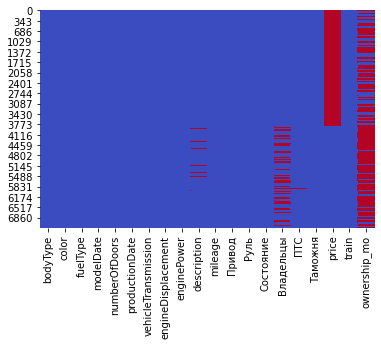

In [31]:
# Пропуски по столбцам в тренировочных данных

print(data[data['train'] == 1].isna().sum())

sns.heatmap(data.isnull(), cbar=False, cmap='coolwarm');

**Вывод**
* 19 признаков (+1 дополненный для различия типов наборов):
    * 8 числовых
    * 12 строковых
* Обнаружено и удалено 315 повторяющихся записей в тренировочном наборе;
* После очистки осталось:
    * 3359 тренировочных записей
    * 3835 проверочных записей
* Немного плохо, что тренировочных данных даже немногим меньше, чем проверочных;
* Пропуски в основном в информации о предыдущих владельцах и времени владении машиной;
* Каждая строка - запись параметров выставленной на продажу машины и её цены (в тренировочном наборе).

---
## 4. Анализ и дополнительная обработка признаков

In [32]:
def categorical_eda(data, feature):
    '''
    Функция, проводящая стандартизированный анализ категориальных признаков.
    '''
    if feature in data.columns:
    
        # Выведем топовые значения в процентном соотношении

        vc = data[feature].value_counts(normalize=True, dropna=False).round(3)

        if len(vc) <= 10:
            vc_adj = vc
        else:
            vc_adj = vc.iloc[:10]
            vc_adj['other'] = 1 - sum(vc.iloc[:10])

        print(vc_adj)
        
        print(f'Кол-во пропусков: {len(data[data[feature].isna()])}')

        # Построим столбцовую диаграмму

        vc_adj.plot(kind='bar', title=feature)
        
    else:
        print(f'Признак {feature} не найден.')
        
    return None

In [33]:
def numerical_eda(data, feature):
    '''
    Функция, проводящая стандартизированный анализ числовых признаков.
    '''
    # Выводим описательные статистики переменной
    
    print(f'Переменная {feature}:\n', data[feature].describe().round(2))
    
    print(f'Кол-во уникальных значений: {data[feature].nunique()}')
    
    print(f'Кол-во пропусков: {len(data[data[feature].isna()])}')
    
    # Рассчитаем кол-во выбросов
    
    q1 = data[feature].quantile(q=0.25, interpolation='midpoint')
    q3 = data[feature].quantile(q=0.75, interpolation='midpoint')
    iqr = q3 - q1
    outliers = data[(data[feature] < q1 - 1.5 * iqr) | (data[feature] > q3 + 1.5 * iqr)]
    
    print(f'Кол-во выбросов: {len(outliers)}, или {round(len(outliers) / len(data), 2)}%.')
    
    sns.distplot(data[feature], kde=False, rug=False);

### bodyType
Тип кузова.

внедорожник 5 дв.       0.456
седан                   0.369
купе                    0.053
хэтчбек 5 дв.           0.035
седан long              0.020
лифтбек                 0.017
седан gran coupe        0.010
универсал 5 дв.         0.009
лифтбек gran turismo    0.009
хэтчбек 3 дв.           0.008
other                   0.014
Name: bodyType, dtype: float64
Кол-во пропусков: 0


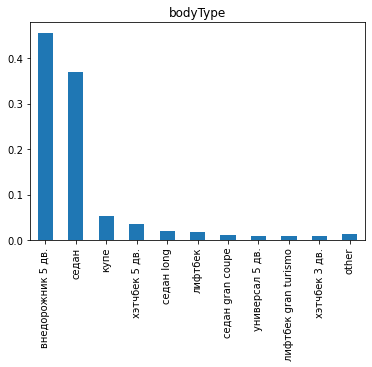

In [34]:
categorical_eda(data, 'bodyType')

In [35]:
data.groupby('train')['bodyType'].value_counts(dropna=False)

train  bodyType              
0      внедорожник 5 дв.         1626
       седан                     1594
       купе                       214
       хэтчбек 5 дв.              163
       лифтбек                    125
       универсал 5 дв.             46
       хэтчбек 3 дв.               36
       кабриолет                   19
       родстер                     10
       компактвэн                   3
       седан 2 дв.                  1
1      внедорожник 5 дв.         1658
       седан                     1062
       купе                       170
       седан long                 147
       хэтчбек 5 дв.               92
       седан gran coupe            73
       лифтбек gran turismo        63
       универсал 5 дв.             21
       кабриолет                   18
       хэтчбек 3 дв.               18
       родстер                     13
       лифтбек gran coupe          12
       компактвэн                   3
       компактвэн gran tourer       3
       седан 2 дв.  

In [36]:
# В тренировочном наборе есть суффиксы, отсутствующие в тесте - уберём их

def replace_text(text):
    
    bodyType_suffixes = [' gran turismo', ' gran coupe', ' gran tourer', ' compact', ' long']
    
    for suffix in bodyType_suffixes:
        if suffix in text:
            return text.replace(suffix, '')
        
    return text


data['bodyType'] = data['bodyType'].apply(replace_text)

**Вывод**
* Внедорожники и седаны представлены больше всего (почти 83%);
* Убраны лишние суффиксы в наименованиях кузовов в тренировочном наборе;
* Пропусков нет.

### color
Цвет машины.

чёрный         0.381
белый          0.198
синий          0.137
серый          0.125
коричневый     0.046
серебристый    0.042
красный        0.029
голубой        0.009
бежевый        0.008
зелёный        0.008
other          0.017
Name: color, dtype: float64
Кол-во пропусков: 0


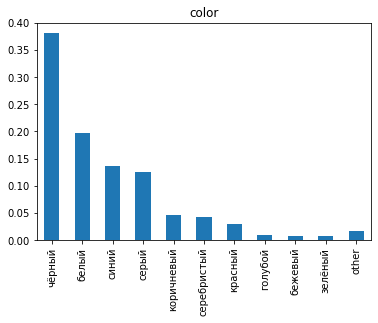

In [37]:
categorical_eda(data, 'color')

In [38]:
# Создадим дополнительный признак популярных и не очень цветов

def color_cat(color):
    
    if color in ['чёрный', 'белый']:
        return 'популярный цвет'
    elif color in ['синий', 'серый', 'коричневый', 'серебристый']:
        return 'частый цвет'
    else:
        return 'редкий цвет'


data['color_cat'] = data['color'].apply(color_cat)

**Вывод**
* Чёрный и белый самые популярные цвета;
* На основании популярности создали дополнительный признак color_cat;
* Пропусков нет.

### fuelType
Тип горючего.

бензин     0.599
дизель     0.398
гибрид     0.003
электро    0.001
Name: fuelType, dtype: float64
Кол-во пропусков: 0


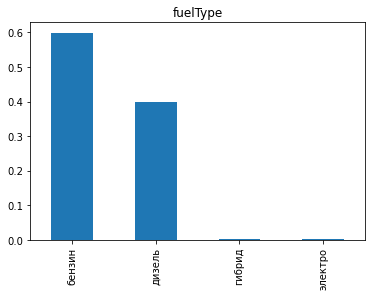

In [39]:
categorical_eda(data, 'fuelType')

In [40]:
# Проверим на наличие дисбалансов

data.groupby(['train', 'fuelType'])['fuelType'].count()

train  fuelType
0      бензин      2471
       гибрид         7
       дизель      1358
       электро        1
1      бензин      1836
       гибрид        12
       дизель      1506
       электро        5
Name: fuelType, dtype: int64

**Вывод**
* Бензин к дизелю в почти идеальной пропорции 60/40 в обоих наборах;
* Пропусков нет.

### modelDate
Год начала выпуска данной модели.

Переменная modelDate:
 count    7196.00
mean     2011.35
std         6.32
min      1936.00
25%      2008.00
50%      2012.00
75%      2016.00
max      2020.00
Name: modelDate, dtype: float64
Кол-во уникальных значений: 40
Кол-во пропусков: 0
Кол-во выбросов: 198, или 0.03%.


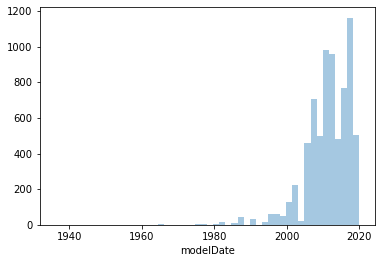

In [41]:
numerical_eda(data, 'modelDate')

In [42]:
# Посмотрим на совсем старые машины - имеет смысл такие машины отдельно обозначить как раритеты

data[data['modelDate'] < 1985].groupby('train')['modelDate'].value_counts()

train  modelDate
0      1982.0       11
       1981.0        3
       1975.0        1
       1977.0        1
1      1982.0        7
       1981.0        4
       1977.0        3
       1975.0        2
       1936.0        1
       1949.0        1
       1965.0        1
       1966.0        1
       1976.0        1
Name: modelDate, dtype: int64

In [43]:
# Создадим новый признак приблизительного поколения машины на основании самой ходовой серии BMW:
# https://en.wikipedia.org/wiki/BMW_3_Series

def generation_cat(modelDate):
    
    if modelDate < 1975:
        return 'раритет'
    elif modelDate >= 1975 and modelDate <= 1982:
        return 'первое'
    elif modelDate >= 1983 and modelDate <= 1992:
        return 'второе'
    elif modelDate >= 1993 and modelDate <= 1999:
        return 'третье'
    elif modelDate >= 2000 and modelDate <= 2006:
        return 'четвёртое'
    elif modelDate >= 2007 and modelDate <= 2012:
        return 'пятое'
    elif modelDate >= 2013 and modelDate <= 2018:
        return 'шестое'
    else:
        return 'седьмое'


data['generation_cat'] = data['modelDate'].apply(generation_cat)

In [44]:
data['generation_cat'].value_counts(dropna=False)

шестое       3037
пятое        2522
четвёртое     829
седьмое       502
третье        183
второе         86
первое         33
раритет         4
Name: generation_cat, dtype: int64

**Вывод**
* Подавляющее большинство машин, представленных в наборе, модели 2008 и более поздних лет, хотя есть и отдельные раритеты (самый старший - 1936 года);
* Создан признак ориентировочного поколения моделей;
* Пропусков нет;
* Распределение смещено вправо, что вполне логично, учитывая сколько машин последних 3 поколений в совокупности.

### numberOfDoors
Кол-во дверей.

5.0    0.530
4.0    0.400
2.0    0.062
3.0    0.008
Name: numberOfDoors, dtype: float64
Кол-во пропусков: 0


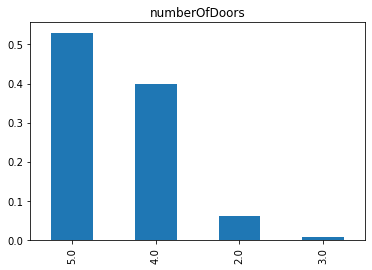

In [45]:
categorical_eda(data, 'numberOfDoors')

**Вывод**
* Только 7% машин с 2-3 дверьми, остальные - стандарт (4-5);
* Пропусков нет.

### productionDate
Год производства конкретной машины.

Переменная productionDate:
 count    7196.00
mean     2013.30
std         6.02
min      1937.00
25%      2011.00
50%      2014.00
75%      2018.00
max      2020.00
Name: productionDate, dtype: float64
Кол-во уникальных значений: 45
Кол-во пропусков: 0
Кол-во выбросов: 245, или 0.03%.


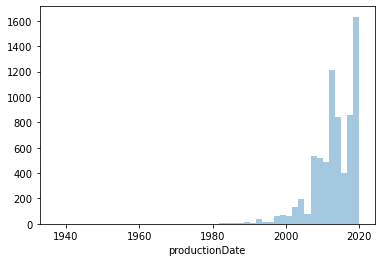

In [46]:
numerical_eda(data, 'productionDate')

**Вывод**
* Очень похожее на modelDate распределение с существенным смещением вправо;
* Пропусков нет.

### vehicleTransmission
Коробка передач.

автоматическая      0.950
механическая        0.030
роботизированная    0.021
Name: vehicleTransmission, dtype: float64
Кол-во пропусков: 0


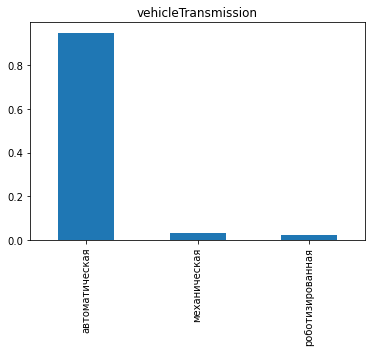

In [47]:
categorical_eda(data, 'vehicleTransmission')

**Вывод**
* Только 5% машин с *не* автоматической коробкой передач;
* Пропусков нет.

### engineDisplacement
Объём двигателя.

2.0      0.396
3.0      0.364
4.4      0.089
2.5      0.048
1.6      0.035
1.5      0.025
4.8      0.013
2.2      0.004
2.8      0.004
4.0      0.003
other    0.019
Name: engineDisplacement, dtype: float64
Кол-во пропусков: 1


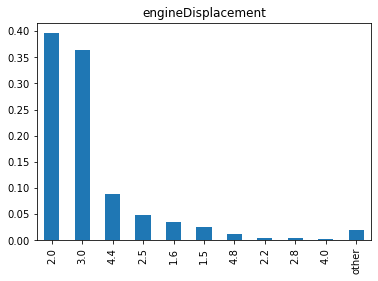

In [48]:
categorical_eda(data, 'engineDisplacement')

In [49]:
# Пропуск в тестовом наборе в одном электромобиле - заполним средним значением для других электромобилей (0)

missing_fuelType = data[data['engineDisplacement'].isna()]['fuelType'].values[0]
missing_enginePower = data[data['engineDisplacement'].isna()]['enginePower'].values[0]

avg_electro_displ = data[(data['fuelType'] == missing_fuelType) & (data['enginePower'] == missing_enginePower) & (~data['engineDisplacement'].isna())]['engineDisplacement'].mean()

data.loc[(data['train'] == 0) & (data['engineDisplacement'].isna()), 'engineDisplacement'] = avg_electro_displ

In [50]:
# Создадим новый признак логарифма объёма двигателя

data['engineDisplacement_log'] = np.log(data['engineDisplacement'] + 1)

**Вывод**
* Преобладают 2- и 3-литровые двигатели (больше 3/4 наблюдений);
* Создан новый признак логарифма объёма двигателя;
* 1 пропущенное значение в тестовом наборе заменено на соответствующее другим электромашинам (0).

### enginePower
Мощность двигателя в л.с.

184.0    0.153
249.0    0.113
190.0    0.075
245.0    0.060
306.0    0.059
150.0    0.046
218.0    0.045
136.0    0.041
258.0    0.027
320.0    0.022
other    0.359
Name: enginePower, dtype: float64
Кол-во пропусков: 0


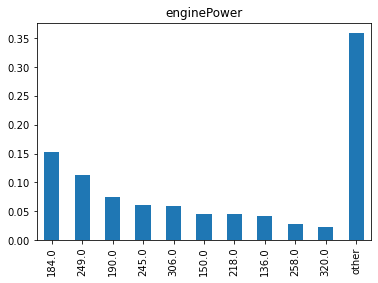

In [51]:
categorical_eda(data, 'enginePower')

**Вывод**
* Существенный разброс мощностей - 2 крупнейшие категории сумарно дают только ~ четверть наблюдений;
* Пропусков нет.

### description
Словесное, неструктурированное описание выставленной на продажу машины.

In [52]:
data['description'].sample(5)

6722    Машина в идеальном состоянии. Готов на любые п...
4040    Автомобиль находится на площадке АО ABTODOM МК...
3057    Состояние отличное. \nКомплект зимних шин в по...
4254    Продаю автомобиль бмв в хорошем состоянии, всв...
5754    Есть вторичный окрас водительской двери и задн...
Name: description, dtype: object

In [53]:
# Создадим признак длины сопутствующего описания

data['description_len'] = data['description'].apply(lambda x: len(x) if isinstance(x, str) else 0)

In [54]:
# Создадим признак наличия камеры и круиз-контроля в машине

data['camera'] = data['description'].apply(lambda x: 1 if (isinstance(x, str) and 'камер' in x) else 0).astype('int32')

data['cruise_control'] = data['description'].apply(lambda x: 1 if (isinstance(x, str) and 'круиз' in x) else 0).astype('int32')

**Вывод**
* Данные неструктурированы, но насколько возможно созданы новые признаки длины описания, наличия камеры и круиз-контроля;
* Без NLP, увы, этот признак дальше вряд ли получится использовать, поэтому удалим его.

### mileage
Пробег в км.

Переменная mileage:
 count       7196.00
mean      100272.87
std        90891.62
min            0.00
25%        22954.75
50%        88982.50
75%       150000.00
max      1000000.00
Name: mileage, dtype: float64
Кол-во уникальных значений: 2966
Кол-во пропусков: 0
Кол-во выбросов: 129, или 0.02%.


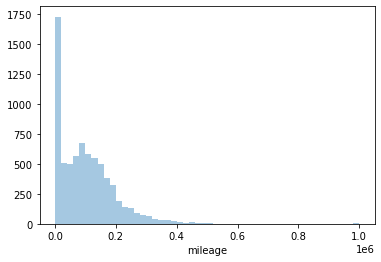

In [55]:
numerical_eda(data, 'mileage')

In [56]:
print(f'Кол-во машин с нулевым пробегом: {data[data["mileage"] == 0]["mileage"].count()}')

Кол-во машин с нулевым пробегом: 1063


In [57]:
# Создадим категориальный признак на основе пробега машины

def mileage_cat(mileage):
    
    if mileage <= 100:
        return 'новая'
    elif mileage > 100 and mileage <= 10000:
        return 'почти новая'
    elif mileage > 10000 and mileage <= 50000:
        return 'умеренный пробег'
    elif mileage > 50000 and mileage <= 150000:
        return 'подержаная'
    elif mileage > 150000 and mileage <= 300000:
        return 'старая'
    else:
        return 'очень старая'

    
data['mileage_cat'] = data['mileage'].apply(mileage_cat)

In [58]:
# Посмотрим на машины с пробегом выше 500 тыс. км. - такие присутствуют и в обоих наборах, хоть и в единичных экземплярах

data[data['mileage'] > 500000].groupby('train')['mileage'].value_counts()

train  mileage  
0      520416.0     1
       1000000.0    1
1      510000.0     1
       511119.0     1
       548000.0     1
       573000.0     1
       659636.0     1
       999999.0     1
       1000000.0    1
Name: mileage, dtype: int64

In [59]:
# Создадим признак среднего пробега в год

current_year = 2021   # Будем считать, что 2020 уже закончен
    
data['mileage_pa'] = data.apply(lambda row: row['mileage'] / (current_year - row['productionDate']) if (current_year - row['productionDate']) > 0 else 0, axis=1)

In [60]:
# Создадим логарифм пробега из-за существенного смещения влево

data['mileage_log'] = np.log(data['mileage'] + 1)

**Вывод**
* Распределение существенно смещено влево - добавлен логарифм пробега;
* Также добавлены дополнительные признаки среднего пробега за год и категориальный признак машины по пробегу;
* Пропусков нет.

### Привод
Тип привода.

полный      0.669
задний      0.319
передний    0.012
Name: Привод, dtype: float64
Кол-во пропусков: 0


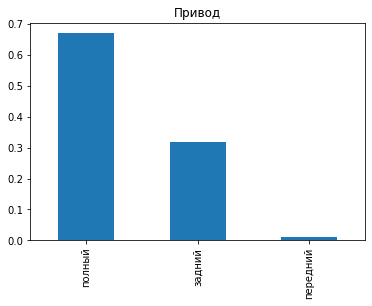

In [61]:
categorical_eda(data, 'Привод')

**Вывод**
* 2/3 машин с полным и почти 1/3 с передним приводами;
* Пропусков нет.

### Руль

Левый     1.0
Правый    0.0
Name: Руль, dtype: float64
Кол-во пропусков: 0


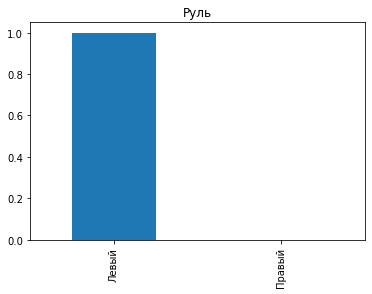

In [62]:
categorical_eda(data, 'Руль')

In [63]:
print(f'Кол-во наблюдений с правым рулём: {len(data[data["Руль"] == "Правый"])}')

print(data[data['Руль'] == 'Правый'].groupby('train')['train'].sum())


# Оба наблюдения с правым рулём в тренировочном наборе, можно удалить без ущерба

data = data[data['Руль'] != 'Правый']

Кол-во наблюдений с правым рулём: 2
train
1    2
Name: train, dtype: int64


**Вывод**
* Только 2 машины с правым рулём, для упрощения удалим эти записи, после чего столбец становится избыточным и его тоже можно удалить;
* Пропусков нет.

### Состояние
Общее состояние машины.

Не требует ремонта    1.0
Name: Состояние, dtype: float64
Кол-во пропусков: 0


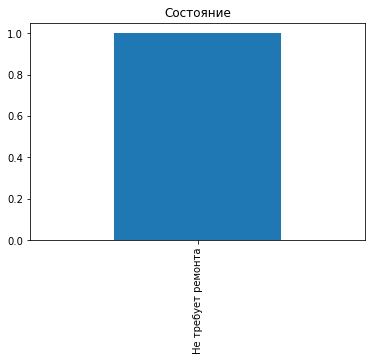

In [64]:
categorical_eda(data, 'Состояние')

**Вывод**
* Присутствуют только машины, не требующие ремонта;
* Столбец излишен, можно удалить.

### Владельцы
Кол-во предыдущих владельцев.

3 или более    0.332
1 владелец     0.295
2 владельца    0.225
NaN            0.148
Name: Владельцы, dtype: float64
Кол-во пропусков: 1063


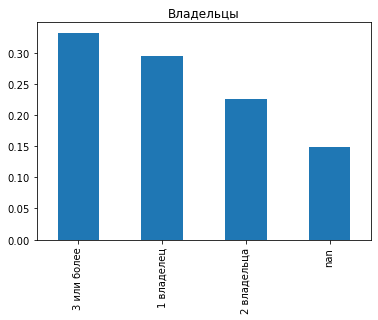

In [65]:
categorical_eda(data, 'Владельцы')

In [66]:
# Смотрим разбитие признака по наборам и пробег у машин

print(data.groupby('train')['Владельцы'].value_counts(dropna=False))

print(f"\nПробег:\n{data[data['Владельцы'].isna()]['mileage'].value_counts(dropna=False)}")

train  Владельцы  
0      3 или более    1516
       1 владелец     1309
       2 владельца    1012
1      NaN            1063
       3 или более     876
       1 владелец      814
       2 владельца     604
Name: Владельцы, dtype: int64

Пробег:
0.0    1063
Name: mileage, dtype: int64


In [67]:
# В тесте странный формат написания для 1 и 2 владельцев - проверим это и поменяем на нормальный пробел

print(f"Было: {data['Владельцы'].value_counts().index.tolist()}")

data['Владельцы'] = data['Владельцы'].str.replace('\xa0', ' ')

print(f"Стало: {data['Владельцы'].value_counts().index.tolist()}")

Было: ['3 или более', '1\xa0владелец', '2\xa0владельца']
Стало: ['3 или более', '1 владелец', '2 владельца']


In [68]:
# Т.к. в тесте нет машин с отсутствующим признаком Владельцы + все такие машины в тренировочном наборе с нулевым пробегом,
# что косвенно обозначает новые машины, присвоим им значение "1 владелец"

data['Владельцы'].fillna('1 владелец', inplace=True)

**Вывод**
* В записях, где эта информация присутствует, в основном представлены более старые машины (2 и более владельцев);
* Почти 15% пропусков - на основании нулевого пробега присвоили им категорию "1 владелец".

### ПТС
Наличие и вид паспорта транспортного средства.

Оригинал    0.906
Дубликат    0.091
NaN         0.003
Name: ПТС, dtype: float64
Кол-во пропусков: 18


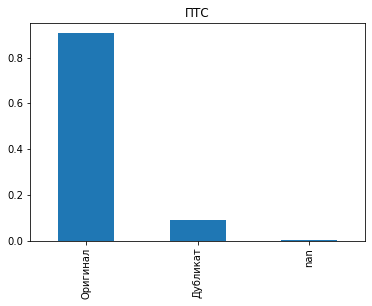

In [69]:
categorical_eda(data, 'ПТС')

In [70]:
data['ПТС'].fillna('неизвестно', inplace=True)

**Вывод**
* У более чем 90% машин ПТС - оригинал;
* 18 пропусков - попробуем создать соответствующую категорию: возможно отсутствие этого показателя имеет эффект на стоимость машины.

### Таможня
Растаможена ли машина?

Растаможен    1.0
Name: Таможня, dtype: float64
Кол-во пропусков: 0


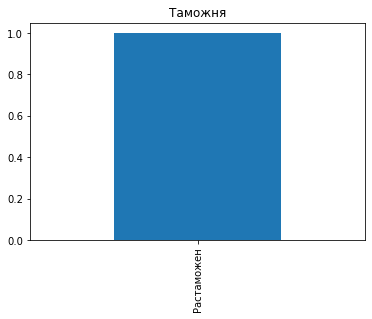

In [71]:
categorical_eda(data, 'Таможня')

**Вывод**
* Присутствуют только растаможенные машины;
* Столбец излишен, можно удалить.

### ownership_mo
Время предыдущего владения в месяцах.

Переменная ownership_mo:
 count    2370.00
mean       44.15
std        37.05
min         0.00
25%        17.00
50%        35.00
75%        65.00
max       515.00
Name: ownership_mo, dtype: float64
Кол-во уникальных значений: 165
Кол-во пропусков: 4824
Кол-во выбросов: 42, или 0.01%.


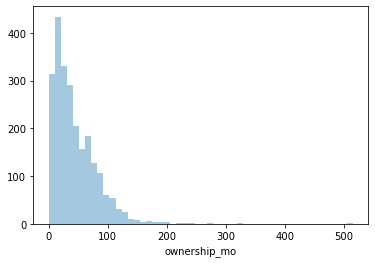

In [72]:
numerical_eda(data, 'ownership_mo')

In [73]:
# Словарь средних значений кол-ва месяцев владения на основании года производства
# и новый признак-среднее для машин данного года производства

avg_by_prodDate = data.groupby(['productionDate'])['ownership_mo'].mean().round().to_dict()

data['avg_by_prodDate'] = data['productionDate'].replace(avg_by_prodDate)


# Для 3 раритетов, где нет подходящего значения дополним общим средним за весь датасет

data['avg_by_prodDate'].fillna(round(data['ownership_mo'].mean()), inplace=True)


# Заполним отсутствующие значения в ownership_mo соответственными средними из новой колонки

data['ownership_mo'].fillna(data['avg_by_prodDate'], inplace=True)

**Вывод**
* Большой разброс значений, хоть и с существенным смещением влево;
* Огромная доля пропущенных значений заполнена средним значением для машин с соответствующим годом выпуска;
* Минимум выбросов после обработки оставим как есть.

### price
Целевая переменная - стоимость машины в рублях.

In [74]:
# Убедимся, что данные в формате числа с плавающей точкой

data['price'] = data['price'].astype('float32')

Переменная price:
 count        3346.00
mean      3417913.50
std       2910822.75
min         55000.00
25%       1300000.00
50%       2649500.00
75%       4181125.00
max      15990100.00
Name: price, dtype: float64
Кол-во уникальных значений: 1622
Кол-во пропусков: 11
Кол-во выбросов: 267, или 0.08%.


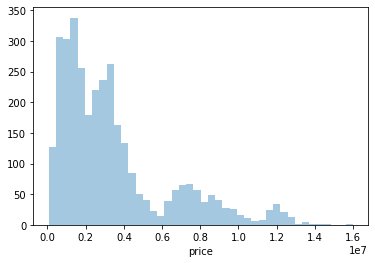

In [75]:
numerical_eda(data[data['train']== 1], 'price')

In [76]:
# Удалим 11 записей без цены в тренировочном наборе

data = data.query('(train == 1 and price == price) or train == 0')

print(len(data))

7183


**Вывод**
* Медианная стоимость машины в тренировочном наборе - 2,65 млн. рублей;
* Существенное стандартное отклонение в 2,9 млн. рублей;
* Большой разброс цен - 1622 уникальных значений на выборке 3335 записей;
* 11 пропусков удалены.

---
## 5. Оценка корреляции и значимости признаков

### Корреляция

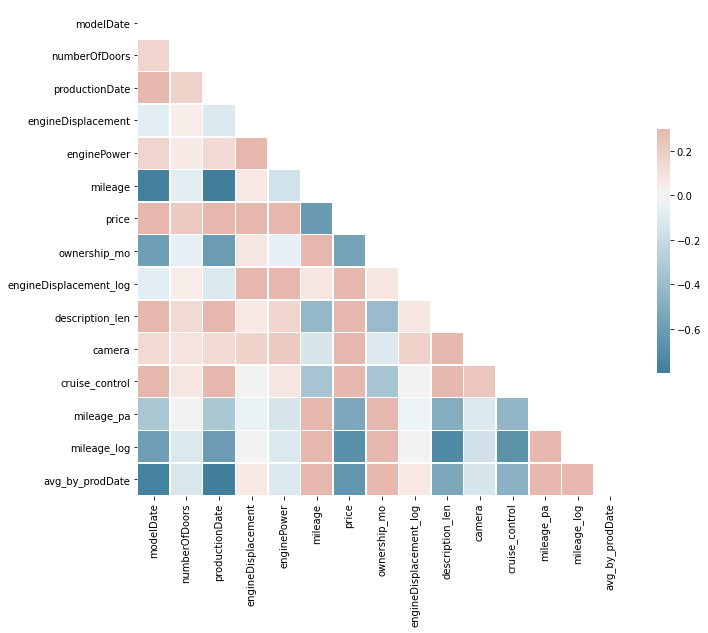

In [77]:
columns = list(data.columns)

columns.remove('train')

corr = data[columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

**Вывод**
* Достаточно слабая положительная корреляция всех числовых переменных с ценой, за исключением пробега;
* Вполне естественна ярко выраженная отрицательная корреляция между пробегом / сроком владения и годом модели / производства. 

### Оценка значимости числовых признаков

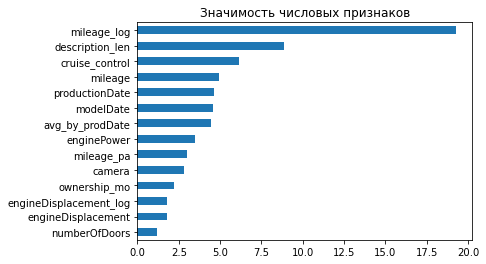

In [78]:
num_cols = list(set(data.columns) - set(data.select_dtypes('object').columns))

num_cols.remove('train')
num_cols.remove('price')

imp_num = pd.Series(f_classif(data[num_cols][data['train'] == 1],
                              data['price'][data['train'] == 1]
                            )[0], index = num_cols)

imp_num.sort_values(inplace = True)

imp_num.plot(kind='barh', title='Значимость числовых признаков');

**Вывод**
* Наиболее существенный вклад имеет логарифм пробега и с большим отрывом длина описания и наличие круиз-контроля;
* Самая меньшая значимость у кол-ва дверей и объёма двигателя.

---
## 6. Подготовка данных к машинному обучению

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7183 entries, 0 to 7195
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bodyType                7183 non-null   object 
 1   color                   7183 non-null   object 
 2   fuelType                7183 non-null   object 
 3   modelDate               7183 non-null   float64
 4   numberOfDoors           7183 non-null   float64
 5   productionDate          7183 non-null   float64
 6   vehicleTransmission     7183 non-null   object 
 7   engineDisplacement      7183 non-null   float64
 8   enginePower             7183 non-null   float64
 9   description             7101 non-null   object 
 10  mileage                 7183 non-null   float64
 11  Привод                  7183 non-null   object 
 12  Руль                    7183 non-null   object 
 13  Состояние               7183 non-null   object 
 14  Владельцы               7183 non-null   

In [80]:
def preproc_data(df_input):
    '''
    Последние шаги обработки данных перед подачей в модель 
    '''
    df_output = df_input.copy()
    
    
    # Убираем ненужные для модели признаки
    df_output.drop(['description', 'Руль', 'Состояние', 'Таможня', 'train'], axis=1, inplace=True)
    
    
    # Переводим признаки из float в int (иначе CatBoost выдаcт ошибку)
    for feature in num_cols:
        df_output[feature] = df_output[feature].astype('int32')
    
    return df_output

In [81]:
# Смотрим не остались ли ещё где пропуски

null_features = pd.Series(data[data['train'] == 0].isna().sum())

print(null_features[null_features > 0])

price    3837
dtype: int64


In [82]:
train_preproc = preproc_data(data[data['train'] == 1])

X_sub = preproc_data(data[data['train'] == 0].drop('price', axis=1))

train_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3346 entries, 3837 to 7195
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bodyType                3346 non-null   object 
 1   color                   3346 non-null   object 
 2   fuelType                3346 non-null   object 
 3   modelDate               3346 non-null   int32  
 4   numberOfDoors           3346 non-null   int32  
 5   productionDate          3346 non-null   int32  
 6   vehicleTransmission     3346 non-null   object 
 7   engineDisplacement      3346 non-null   int32  
 8   enginePower             3346 non-null   int32  
 9   mileage                 3346 non-null   int32  
 10  Привод                  3346 non-null   object 
 11  Владельцы               3346 non-null   object 
 12  ПТС                     3346 non-null   object 
 13  price                   3346 non-null   float32
 14  ownership_mo            3346 non-null

In [83]:
X = train_preproc.drop(['price'], axis=1)


# Учитываем разницу в курсах с момента скачивания тестового набора

y = train_preproc['price'].values * FX_COEF

---
## 7. Построение первичной модели

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [85]:
# Keep list of all categorical features in dataset to specify this for CatBoost

cat_features_ids = np.where(X_train.apply(pd.Series.nunique) < 3000)[0].tolist()

In [86]:
model = CatBoostRegressor(iterations=ITERATIONS,
                          learning_rate=LR,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )

model.fit(X_train, y_train,
          cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=500,
          use_best_model=True,
          plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.4790864	test: 1.5133355	best: 1.5133355 (0)	total: 74.8ms	remaining: 2m 29s
500:	learn: 0.1099205	test: 0.1445019	best: 0.1436740 (369)	total: 9.68s	remaining: 29s
1000:	learn: 0.0812048	test: 0.1431602	best: 0.1423564 (787)	total: 20.9s	remaining: 20.8s
1500:	learn: 0.0628637	test: 0.1417793	best: 0.1417077 (1464)	total: 32.1s	remaining: 10.7s
1999:	learn: 0.0507896	test: 0.1417044	best: 0.1412061 (1712)	total: 44.4s	remaining: 0us

bestTest = 0.1412060508
bestIteration = 1712

Shrink model to first 1713 iterations.


In [87]:
model.save_model('catboost_single_model_baseline.model')

**Вывод**
* На данном этапе MAPE = 0.141

---
## 8. Кросс-валидация

In [88]:
# Функция-обёртка для модели CatBoost

def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations=ITERATIONS,
                              learning_rate=LR,
                              eval_metric='MAPE',
                              random_seed=RANDOM_SEED
    )
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False
    )
    
    return(model)

In [89]:
# Функция для подсчёта MAPE (kwargs - для использования в оценке кросс-валидации) и соответствующий оценщик

def mape(y_true, y_pred, **kwargs):
    return np.mean(np.abs((y_pred-y_true)/y_true))


mape_scorer = make_scorer(mape, greater_is_better=False)

In [90]:
# В эту переменную пишем предикты по каждой модели
submissions = pd.DataFrame(0, columns=["sub_1"], index=sample_submission.index)
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))


for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS):

    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test)
    
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.151
2 Fold Test MAPE: 0.120
3 Fold Test MAPE: 0.129
4 Fold Test MAPE: 0.164
5 Fold Test MAPE: 0.136

Mean Score: 0.140
Std Score: 0.0158
Max Score: 0.164
Min Score: 0.120


In [91]:
submissions.head()

,sub_1,sub_2,sub_3,sub_4,sub_5
0,1.695152e+06,1.702362e+06,1.667711e+06,1.690942e+06,1.783018e+06
1,2.485984e+06,2.453273e+06,2.260133e+06,2.614691e+06,2.409448e+06
2,1.288867e+06,1.289252e+06,1.287255e+06,1.263310e+06,1.200349e+06
3,2.532587e+06,2.445128e+06,2.441209e+06,2.414320e+06,2.450023e+06
4,3.786567e+06,4.301874e+06,4.030129e+06,3.844539e+06,4.224767e+06


In [92]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)

# Округляем предсказания до ближайшей тысячи
sample_submission['price'] = submissions['blend'].apply(lambda x: round(x / 1000) * 1000).values

sample_submission.to_csv(f'submission_blend_v{VERSION}.csv', index=False)
sample_submission.head()

,id,price
0,0,1708000
1,1,2445000
2,2,1266000
3,3,2457000
4,4,4038000


**Вывод**
* На данном этапе лучшее значение MAPE = 0.120

---
## 9. Стекинг

In [93]:
# Теперь добавим dummy-переменные к категориальным признакам

cat_columns = train_preproc.select_dtypes('object').columns

train = pd.get_dummies(train_preproc, prefix=cat_columns, columns=cat_columns)

test = pd.get_dummies(X_sub, prefix=cat_columns, columns=cat_columns)

In [94]:
# Колонки в тренировочном наборе, которых нет в тестовом

added_cols_train = list(set(train.columns) - set(test.columns))

added_cols_train.remove('price')

train[added_cols_train].sum()

ПТС_неизвестно            18
generation_cat_раритет     4
bodyType_купе-хардтоп      1
dtype: int64

In [95]:
# Признаки в тестовом наборе, которых нет в тренировочном

added_cols_test = list(set(test.columns) - set(train.columns))

test[added_cols_test].sum()

Series([], dtype: float64)

In [96]:
# Удалим признаки, которых нет в обоих наборах данных

train.drop(added_cols_train, axis=1, inplace=True)

test.drop(added_cols_test, axis=1, inplace=True)

In [97]:
X = train.drop(['price'], axis=1)

y = train['price'].values * FX_COEF

In [98]:
cbr = CatBoostRegressor(iterations=ITERATIONS,
                        learning_rate=LR,
                        random_seed=RANDOM_SEED,
                        silent=True)

linr = LinearRegression()

dtr = DecisionTreeRegressor(random_state=RANDOM_SEED)

rf = RandomForestRegressor(n_estimators=400, 
                           random_state=RANDOM_SEED,
                           n_jobs=-1)

stack = StackingCVRegressor(regressors=(cbr, linr, dtr, rf),
                            meta_regressor=rf,
                            random_state=RANDOM_SEED)

print(f'{N_FOLDS}-fold cross validation scores:\n')

for clf, label in zip([cbr, linr, dtr, rf, stack],
                      ['CatBoost', 'Linear Regression', 'Decision Tree',
                       'Random Forest', 'StackingCVRegressor']):
    
    scores = cross_val_score(clf, X, y, cv=N_FOLDS, scoring=mape_scorer)
    print("MAPE: %0.3f (+/- %0.3f) [%s]" % (
        scores.mean(), scores.std(), label)
    )

5-fold cross validation scores:

MAPE: -0.147 (+/- 0.033) [CatBoost]
MAPE: -0.492 (+/- 0.107) [Linear Regression]
MAPE: -0.178 (+/- 0.041) [Decision Tree]
MAPE: -0.134 (+/- 0.029) [Random Forest]
MAPE: -0.146 (+/- 0.033) [StackingCVRegressor]


In [99]:
# Тренируем модель на стеке

stack.fit(X, y)

StackingCVRegressor(meta_regressor=RandomForestRegressor(n_estimators=400,
                                                         n_jobs=-1,
                                                         random_state=42),
                    random_state=42,
                    regressors=(<catboost.core.CatBoostRegressor object at 0x7f2b75f2a810>,
                                LinearRegression(),
                                DecisionTreeRegressor(random_state=42),
                                RandomForestRegressor(n_estimators=400,
                                                      n_jobs=-1,
                                                      random_state=42)))

**Вывод**
* MAPE, полученный с помощью стекинга оказался хуже (в среднем 0.146), чем полученный на CatBoost-e.

---
## 10. Предсказание на проверочных данных

In [100]:
predict_submission = stack.predict(test)

# Округляем предсказания до ближайшей тысячи
sample_submission['price'] = np.round(predict_submission / 1000) * 1000

sample_submission.to_csv(f'submission_stack_v{VERSION}.csv', index=False)
sample_submission.sample(5)

,id,price
3344,3344,2865000.0
223,223,1109000.0
2248,2248,732000.0
136,136,2222000.0
444,444,368000.0


---
## 11. Итоги и выводы
* Проект оказался на пределе возможностей знаний, но от того не менее интересный;
* Обнаружилось много технических нюансов в парсинге, при этом Авто.ру очень щедро делился данными, что в нынешнее время довольно-таки редкость для крупного портала :)
* CatBoost оказалась очень интересной библиотекой, которая прямо "из коробки" показывает отличные результаты и берёт на себя львиную долю предобработки данных - жаль, что мы её не рассмотрели ближе в материалах курса;
* Получилось расширить арсенал функций того, чем ещё не приводилось пользоваться в pandas, напр. ф-ия select_dtypes() или изменение только части датафрейма по определённым критериям;
* Интересно, что признаки, которыми дополнил изначальный датасет в совокупности ухудшили результат, хоть большинство из них явно и имеют логическую связь и эффект на стоимость;
* В этот раз наконец-то реализовал инкапсуляцию повторяющегося кода в виде функций, напр. для EDA и анализа наборов, что существенно сократило время разработки и, хочется верить, помогло избежать ошибок по невнимательности;
* На стекинг как таковой осталось достаточно мало времени, что скорее всего и сказалось на конечном результате, когда "голый" CatBoost смог показать лучший результат. Здесь ещё придётся поиграться и посмотреть, напр. как в данном случае его можно совместить с мета-параметрами (grid search) и бэггингом. По-любому круто, что получилось первый раз его реализовать, хоть и с помощью сторонней библиотеки.